In [ ]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing
from sklearn.utils import shuffle

## Forecasting

We will work with the weather dataset from Jena, Germany. It is provided by the Max Planck Institute and can be downloaded from Keras datasets.

In [ ]:
tf.keras.utils.get_file('weather_data.zip',
                        'https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip',
                        cache_dir='./',
                        cache_subdir='datasets/weather',
                        extract=True)

'./datasets/weather/weather_data.zip'

### Data exploration

In [ ]:
# Import the data as a DataFrame for simple exploration.

df = pd.read_csv('./datasets/weather/jena_climate_2009_2016.csv')
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000
mean,989.212508,9.448567,283.491182,4.954011,76.007045,13.575089,9.532524,4.042483,6.021630,9.638982,1216.069883,2.130309,3.532381,174.726164
std,8.359454,8.423685,8.504820,6.730411,16.477126,7.739481,4.183895,4.897270,2.655973,4.235130,39.977065,1.541830,2.340482,86.675965
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,0.000000,0.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.800000
50%,989.570000,9.410000,283.460000,5.210000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.800000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.480000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,14.630000,23.500000,360.000000


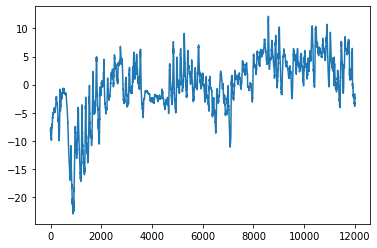

In [ ]:
# We will focus on the temperature as the quantity of interest.

plt.plot(df['T (degC)'][:12000])

### Prepare datasets for a deep neural network model


In [ ]:
# Let us separate the timestamps instead of which we can use the index.

df_timestamps = df['Date Time']
df = df.drop(columns='Date Time')

In [ ]:
# Create a copy of the temperatur column which will act as our labels.

temps = df['T (degC)'].copy()

In [ ]:
temps_mean = temps.mean()
temps_std = temps.std()

temps = (temps-temps_mean)/temps_std

In [ ]:
# Normalize the data.

df = (df - df.mean())/df.std()

In [ ]:
# Create time series datasets which package data in a sliding window.

# The number of samples included in our sliding window, analogous to the 
# kernel size in Convnets.
window_size = 120

# Analogous to strides in Convnets, the number of data points to skip when
# sampling data from the window.
strides = 6

# How far into the future is the target of prediction.
delay = strides * (window_size + 24 - 1)


# Choose how to split the datasets to training, validation and test datasets.
num_train = int(0.3 * len(df))
num_valid = int(0.2 * len(df))
num_test = len(df) - num_train - num_valid
batch_size = 256


train_dataset = keras.utils.timeseries_dataset_from_array(
    df[:-delay],
    targets=temps[delay:],
    sampling_rate=strides,
    sequence_length=window_size,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train)

valid_dataset = keras.utils.timeseries_dataset_from_array(
    df[:-delay],
    targets=temps[delay:],
    sampling_rate=strides,
    sequence_length=window_size,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train,
    end_index=num_train + num_valid)

test_dataset = keras.utils.timeseries_dataset_from_array(
    df[:-delay],
    targets=temps[delay:],
    sampling_rate=strides,
    sequence_length=window_size,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train + num_valid)

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### Baseline model

In [ ]:
model_input = keras.Input(shape=(window_size, df.shape[-1]))
x = layers.Flatten()(model_input)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1)(x)
model_dense = keras.Model(model_input, x)

model_dense.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [ ]:
model_dense.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 flatten_3 (Flatten)         (None, 1680)              0         
                                                                 
 dense_6 (Dense)             (None, 16)                26896     
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 26,913
Trainable params: 26,913
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_dense.fit(train_dataset,
                          epochs=4,
                          validation_data=valid_dataset)

Epoch 1/4
490/490 [==============================] - 42s 85ms/step - loss: 0.4897 - mae: 0.5234 - val_loss: 0.2305 - val_mae: 0.3808
Epoch 2/4
490/490 [==============================] - 43s 88ms/step - loss: 0.2948 - mae: 0.4170 - val_loss: 0.1859 - val_mae: 0.3402
Epoch 3/4
490/490 [==============================] - 43s 87ms/step - loss: 0.2642 - mae: 0.3936 - val_loss: 0.1786 - val_mae: 0.3335
Epoch 4/4
490/490 [==============================] - 42s 86ms/step - loss: 0.2491 - mae: 0.3813 - val_loss: 0.1586 - val_mae: 0.3134


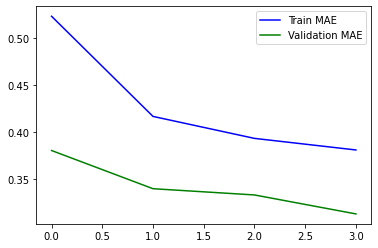

In [ ]:
plt.plot(history.history['mae'], c='b')
plt.plot(history.history['val_mae'], c='g')
plt.legend(['Train MAE', 'Validation MAE'])
plt.show()

In [ ]:
model_dense.evaluate(test_dataset)

816/816 [==============================] - 46s 56ms/step - loss: 0.1473 - mae: 0.3030


[0.14731527864933014, 0.30304598808288574]

In [ ]:
y_pred = np.zeros(shape=(0), dtype='float32')
y_true = np.zeros(shape=(0), dtype='float32')
for samples, targets in test_dataset:
    y_pred = np.concatenate([y_pred, model_dense.predict(samples).reshape((-1))], axis=0)
    y_true = np.concatenate([y_true, targets], axis=0)

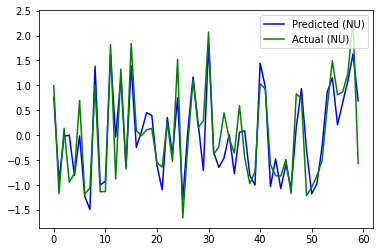

In [ ]:
plt.plot(y_pred[:60], c='b')
plt.plot(y_true[:60], c='g')
plt.legend(['Predicted (NU)', 'Actual (NU)'])
plt.show()

### Convnet model

In [ ]:
model_input = keras.Input(shape=(window_size, df.shape[-1]))
x = layers.Conv1D(16, 4, activation="relu")(model_input)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1)(x)

model_conv = keras.Model(model_input, x)

callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=5,
                                         restore_best_weights=True)

model_conv.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [ ]:
model_conv.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 conv1d (Conv1D)             (None, 117, 16)           912       
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 929
Trainable params: 929
Non-trainable params: 0
_____________________________________________________________

In [ ]:
history = model_conv.fit(train_dataset,
                         epochs=4,
                         validation_data=valid_dataset,
                         callbacks=callback)

Epoch 1/4
490/490 [==============================] - 47s 96ms/step - loss: 0.4390 - mae: 0.5226 - val_loss: 0.3531 - val_mae: 0.4652
Epoch 2/4
490/490 [==============================] - 49s 100ms/step - loss: 0.3964 - mae: 0.4973 - val_loss: 0.3490 - val_mae: 0.4639
Epoch 3/4
490/490 [==============================] - 49s 99ms/step - loss: 0.3924 - mae: 0.4947 - val_loss: 0.3501 - val_mae: 0.4642
Epoch 4/4
490/490 [==============================] - 47s 95ms/step - loss: 0.3890 - mae: 0.4928 - val_loss: 0.3492 - val_mae: 0.4640


In [ ]:
model_conv.evaluate(test_dataset)

816/816 [==============================] - 59s 71ms/step - loss: 0.3047 - mae: 0.4359


[0.3047023415565491, 0.4359057545661926]

### Convnet with delayed input

In [ ]:
model_input = keras.Input(shape=(window_size, df.shape[-1]))
x = layers.ZeroPadding1D(4)(model_input)
x = layers.Lambda(lambda x: x[:,:-8,:])(x)


# For timeseries it's important to ignore padding during training.
# We do that with the Masking layer.
x = layers.Masking()(x)

x = layers.Concatenate(axis=2)([model_input, x])
x = layers.Conv1D(16, 2, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1)(x)

model_conv_d = keras.Model(model_input, x)

callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=5,
                                         restore_best_weights=True)

model_conv_d.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [ ]:
model_conv_d.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 120, 14)]    0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 128, 14)     0           ['input_6[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 120, 14)      0           ['zero_padding1d[0][0]']         
                                                                                                  
 masking (Masking)              (None, 120, 14)      0           ['lambda[0][0]']                 
                                                                                            

In [ ]:
history = model_conv_d.fit(train_dataset,
                           epochs=4,
                           validation_data=valid_dataset,
                           callbacks=callback)

Epoch 1/4
490/490 [==============================] - 52s 105ms/step - loss: 0.5869 - mae: 0.6028 - val_loss: 0.3561 - val_mae: 0.4676
Epoch 2/4
490/490 [==============================] - 52s 106ms/step - loss: 0.4204 - mae: 0.5127 - val_loss: 0.3479 - val_mae: 0.4624
Epoch 3/4
490/490 [==============================] - 51s 104ms/step - loss: 0.4010 - mae: 0.4998 - val_loss: 0.3367 - val_mae: 0.4574
Epoch 4/4
490/490 [==============================] - 51s 103ms/step - loss: 0.3896 - mae: 0.4917 - val_loss: 0.3398 - val_mae: 0.4562


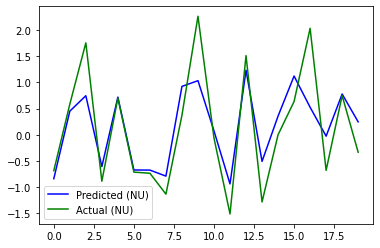

In [ ]:
y_pred = np.zeros(shape=(0), dtype='float32')
y_true = np.zeros(shape=(0), dtype='float32')
for samples, targets in test_dataset:
    y_pred = np.concatenate([y_pred, model_conv_d.predict(samples).reshape((-1))], axis=0)
    y_true = np.concatenate([y_true, targets], axis=0)

plt.plot(y_pred[:20], c='b')
plt.plot(y_true[:20], c='g')
plt.legend(['Predicted (NU)', 'Actual (NU)'])
plt.show()

In [ ]:
model_conv_d.evaluate(test_dataset)

## Simple RNN

In [ ]:
model_input = keras.Input(shape=(window_size, df.shape[-1]))
x = layers.SimpleRNN(16, dropout=0.3, activation="relu")(model_input)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1)(x)

model_SRNN = keras.Model(model_input, x)

callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=5,
                                         restore_best_weights=True)

model_SRNN.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [ ]:
model_SRNN.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 16)                496       
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_SRNN.fit(train_dataset,
                         epochs=4,
                         validation_data=valid_dataset,
                         callbacks=callback)

Epoch 1/4
490/490 [==============================] - 71s 142ms/step - loss: 1.3348 - mae: 0.7642 - val_loss: 0.2341 - val_mae: 0.3839
Epoch 2/4
490/490 [==============================] - 77s 157ms/step - loss: 0.3920 - mae: 0.4779 - val_loss: 0.2216 - val_mae: 0.3713
Epoch 3/4
490/490 [==============================] - 75s 152ms/step - loss: 0.3412 - mae: 0.4460 - val_loss: 0.2049 - val_mae: 0.3579
Epoch 4/4
490/490 [==============================] - 59s 120ms/step - loss: 0.3228 - mae: 0.4350 - val_loss: 0.2074 - val_mae: 0.3591


In [ ]:
model_SRNN.evaluate(test_dataset)

816/816 [==============================] - 50s 61ms/step - loss: 0.1709 - mae: 0.3268


[0.17085379362106323, 0.32678738236427307]

### LSTM

In [ ]:
model_input = keras.Input(shape=(window_size, df.shape[-1]))
x = layers.LSTM(8, dropout=0.4, activation="relu")(model_input)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1)(x)

model_LSTM = keras.Model(model_input, x)

callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=5,
                                         restore_best_weights=True)

model_LSTM.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [ ]:
model_LSTM.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 lstm (LSTM)                 (None, 8)                 736       
                                                                 
 dropout_8 (Dropout)         (None, 8)                 0         
                                                                 
 dense_12 (Dense)            (None, 1)                 9         
                                                                 
Total params: 745
Trainable params: 745
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_LSTM.fit(train_dataset,
                         epochs=4,
                         validation_data=valid_dataset,
                         callbacks=callback)

Epoch 1/4
490/490 [==============================] - 74s 146ms/step - loss: 13736.6533 - mae: 1.3820 - val_loss: 1.1544 - val_mae: 0.8363
Epoch 2/4
490/490 [==============================] - 73s 147ms/step - loss: 1.4138 - mae: 0.8782 - val_loss: 0.8881 - val_mae: 0.7281
Epoch 3/4
490/490 [==============================] - 73s 148ms/step - loss: 1.3231 - mae: 0.8407 - val_loss: 0.8094 - val_mae: 0.6916
Epoch 4/4
490/490 [==============================] - 74s 150ms/step - loss: 1.3005 - mae: 0.8332 - val_loss: 0.7832 - val_mae: 0.6799


In [ ]:
model_LSTM.evaluate(test_dataset)

### Stacked LSTMs

In [ ]:
model_input = keras.Input(shape=(window_size, df.shape[-1]))
x = layers.LSTM(4, dropout=0.3, activation="relu", return_sequences=True)(model_input)
x = layers.LSTM(4, dropout=0.3, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1)(x)

model_LSTM2 = keras.Model(model_input, x)

callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=5,
                                         restore_best_weights=True)

model_LSTM2.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [ ]:
model_LSTM2.summary()

In [ ]:
history = model_LSTM2.fit(train_dataset,
                          epochs=4,
                          validation_data=valid_dataset,
                          callbacks=callback)

### Bi-directional LSTM

### Compare with GRU layers